---
title: MNIST
categories: deep-learning
date: 2020-10-26
---
[MNIST](https://eipi10.cn/others/2020/10/22/dataset/)（Mixed National Institute of Standards and Technology）数据集是著名的手写数字数据集，被誉为数据科学领域的`果蝇`。本文使用pytorch和tensorflow实现对MNIST数据集进行分类，先从经典神经网络开始，然后使用LeNet，最后还尝试了用相同的算法对[Fashion MNIST](https://eipi10.cn/others/2020/10/22/dataset/#fashion-mnist)数据集进行分类。

## 经典神经网络

首先，尝试用经典的神经网络来进行分类。

### pytorch

In [14]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)


class TaskTime:
    def __init__(self, task_name, show_start=False):
        self.show_start = show_start
        self.task_name = task_name
        self.start_time = time.time()

    def elapsed_time(self):
        return time.time()-self.start_time

    def __enter__(self):
        if self.show_start:
            logging.info('start {}'.format(self.task_name))
        return self;

    def __exit__(self, exc_type, exc_value, exc_tb):
        time.sleep(0.5)
        logging.info('finish {} [elapsed time: {:.2f} seconds]'.format(self.task_name, self.elapsed_time()))

    
def compute_loss_accuarcy(net, loader, criterion, use_cuda=False, max_load_times=0):
    num_correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            if max_load_times>0 and i>=max_load_times: break
            inputs, labels = data
            _, loss, correct = forward(net, inputs, labels, criterion, use_cuda) 
            total += labels.size(0)
            total_loss += loss*labels.size(0)
            num_correct += correct    

    return total_loss/total, num_correct/total

def forward(net, inputs, labels, criterion, use_cuda=False):   
    if use_cuda and  torch.cuda.is_available(): 
        net = net.cuda()
        criterion = criterion.cuda()
        inputs = inputs.cuda()
        labels = labels.cuda()
    outputs = net(inputs)
    loss = criterion(outputs, labels)   
    _, predicted = torch.max(outputs.data, 1)
    num_correct = (predicted == labels).sum().item()
    num_total = labels.size(0)     
    return outputs, loss, num_correct        
    
def train(net, criterion, optimizer, trainloader, validationloader, epochs=2, use_cuda=False):  
        
    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []      
    
    for epoch in range(epochs):         
        train_loss = 0.0
        train_num_correct = 0
        train_total = 0                   
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data   
            # 正向传播
            _, loss, correct = forward(net, inputs, labels, criterion, use_cuda)  
            
            train_loss += loss.item()*labels.size(0)
            train_num_correct += correct
            train_total += labels.size(0)     
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                        
            if i % 50 == 49:        
                sys.stdout.write('\r[epoch %2d/%d %5d] loss: %.3f, accuracy: %.3f' % 
                                  (epoch + 1, epochs, i+1, train_loss/train_total, train_num_correct/train_total))                
                train_loss = 0.0
                train_num_correct = 0
                train_total = 0                   
                                                                                
        train_loss, train_accuracy = compute_loss_accuarcy(net, trainloader, criterion, 
                                                           use_cuda=True, max_load_times=50)   
        val_loss, val_accuracy = compute_loss_accuarcy(net, validationloader, criterion, 
                                                       use_cuda=True, max_load_times=50)
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)         
        
        sys.stdout.write('\r[epoch %2d/%d] loss: %.3f, accuracy: %.3f, val_loss: %.3f, val_accuracy: %.3f \n' %
                          (epoch + 1, epochs, train_loss, train_accuracy, val_loss, val_accuracy))
         

    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list
                
class NN(nn.Module):
    def __init__(self, in_dim=1, n_class=10, p=0.2):
        super(NN, self).__init__()    

        self.fc1 = nn.Linear(28*28, 128)  
        self.fc2 = nn.Linear(128, n_class)
        
        self.drop_layer = nn.Dropout(p=p)
          
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        x = self.fc2(x)
        return x

下面是数据加载的代码。

2020-11-01 07:39:26,900: INFO: start 获取数据
2020-11-01 07:39:27,431: INFO: finish 获取数据 [elapsed time: 0.53 seconds]
2020-11-01 07:39:27,432: INFO: start 显示图片示例


torch.Size([32, 1, 28, 28])
    9     8     3     2     8     1     8     5


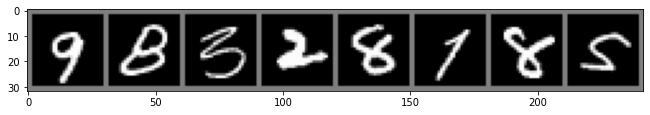

2020-11-01 07:39:28,150: INFO: finish 显示图片示例 [elapsed time: 0.72 seconds]


In [4]:
def torch_mnist_extract_data(dataset='mnist', classes=None):
    with TaskTime('获取数据', True):
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize(mean=(0.5), std=(0.5))])
        data_path = os.path.join(os.path.expanduser('~'), '.pytorch/datasets') 
        if not os.path.exists(data_path): os.makedirs(data_path)
        if dataset=='mnist':
            trainset = torchvision.datasets.MNIST(root=os.path.join(data_path, dataset), train=True,
                                                  download=True, transform=transform)
            trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                                      shuffle=True, num_workers=2)

            testset = torchvision.datasets.MNIST(root=os.path.join(data_path, dataset), train=False,
                                                 download=True, transform=transform)
            testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                                     shuffle=False, num_workers=2)
        else:
            trainset = torchvision.datasets.FashionMNIST(root=os.path.join(data_path, dataset), train=True,
                                                          download=True, transform=transform)
            trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                                      shuffle=True, num_workers=2)

            testset = torchvision.datasets.FashionMNIST(root=os.path.join(data_path, dataset), train=False,
                                                        download=True, transform=transform)
            testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                                     shuffle=False, num_workers=2)           

    with TaskTime('显示图片示例', True):
        plt.rcParams['figure.figsize'] = (12.0, 1.5) 
        def imshow(img):
            img = img / 2 + 0.5     # unnormalize
            npimg = img.numpy()
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
            plt.show()

        # get some random training images
        dataiter = iter(trainloader)
        images, labels = dataiter.next()
        print(images.shape)

        # show images
        print(' '.join('%5s' %  labels[j].item() if classes is None else classes[labels[j].item()] for j in range(8)))
        imshow(torchvision.utils.make_grid(images[0:8]))

    return trainset, trainloader, testset, testloader

trainset, trainloader, testset, testloader = torch_mnist_extract_data()    
   

![image-20201026111108647](images/image-20201026111108647.png)

接下来是模型创建，模型训练，保存加载，以及模型评估的代码。

2020-11-01 07:45:46,481: INFO: start 创建模型


NN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (drop_layer): Dropout(p=0.2, inplace=False)
)


2020-11-01 07:45:46,985: INFO: finish 创建模型 [elapsed time: 0.50 seconds]
2020-11-01 07:45:46,986: INFO: start 显示参数


4
torch.Size([128, 784])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


2020-11-01 07:45:47,489: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 07:45:47,490: INFO: start 模型训练


[epoch  1/5] loss: 0.268, accuracy: 0.914, val_loss: 0.287, val_accuracy: 0.905 
[epoch  2/5] loss: 0.210, accuracy: 0.932, val_loss: 0.257, val_accuracy: 0.912 
[epoch  3/5] loss: 0.152, accuracy: 0.954, val_loss: 0.232, val_accuracy: 0.932 
[epoch  4/5] loss: 0.153, accuracy: 0.951, val_loss: 0.237, val_accuracy: 0.929 
[epoch  5/5] loss: 0.135, accuracy: 0.954, val_loss: 0.176, val_accuracy: 0.945 


2020-11-01 07:46:40,586: INFO: finish 模型训练 [elapsed time: 53.10 seconds]
2020-11-01 07:46:40,588: INFO: start 保存，加载模型
2020-11-01 07:46:41,094: INFO: finish 保存，加载模型 [elapsed time: 0.51 seconds]
2020-11-01 07:46:41,096: INFO: start 评估模型


Train Accuracy: 0.958, Test Accuracy: 0.954


2020-11-01 07:46:52,912: INFO: finish 评估模型 [elapsed time: 11.82 seconds]


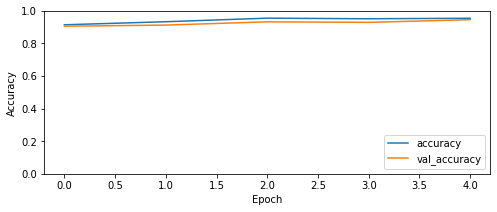

In [15]:
def torch_train_evaluate(net, epochs=10, save_model=False, model_file_name='torch_nn.pth'):                   
    with TaskTime('显示参数', True):
         # 由于存在bias，所以每一层都有两个参数张量，共有10个参数张量。
        params = list(net.parameters())
        print(len(params))
        for param in params:
            print(param.size())  

    with TaskTime('模型训练', True):
        criterion = nn.CrossEntropyLoss()
        # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)      # Adam优化的速度比SGD明显要快
        optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        _, train_accuracy_list, _, val_accuracy_list = train(
            net, criterion, optimizer, trainloader, testloader, epochs=epochs, use_cuda=True)

    if save_model:  
        with TaskTime('保存，加载模型', True):
            model_root_path = os.path.join(os.path.expanduser('~'), '.pytorch/model') 
            if not os.path.exists(model_root_path): os.makedirs(model_root_path)
            model_path = os.path.join(model_root_path, model_file_name)
            torch.save(net.state_dict(), model_path) 
            net.load_state_dict(torch.load(model_path))     

    with TaskTime('评估模型', True):
        plt.figure(figsize=(8, 3))
        plt.plot(train_accuracy_list, label='accuracy')
        plt.plot(val_accuracy_list, label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        plt.legend(loc='lower right')          
        
        _, train_accuracy = compute_loss_accuarcy(net, trainloader, criterion, use_cuda=True)   
        _, test_accuracy = compute_loss_accuarcy(net, testloader, criterion, use_cuda=True)
        print('Train Accuracy: {:0.3f}, Test Accuracy: {:0.3f}'.format(train_accuracy, test_accuracy)) 
        
with TaskTime('创建模型', True):      
    net = NN(in_dim=1, n_class=10)
    print(net)

torch_train_evaluate(net, epochs=5, save_model=True, model_file_name='torch_nn.pth')

![image-20201026113344634](images/image-20201026113344634.png)

Accuracy超过95%，应该来说，效果非常不错。

### tensorflow

In [16]:
import logging
import os
import tensorflow as tf
import time
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

# 设置GPU内存使用上限
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
)

def neural_network():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10))    
    return model

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


然后加载数据。

2020-11-01 07:48:49,473: INFO: start 获取数据


(60000, 28, 28) (60000,) (60000, 28, 28) (10000,)
<class 'numpy.ndarray'> <class 'tuple'>


2020-11-01 07:48:50,606: INFO: finish 获取数据 [elapsed time: 1.13 seconds]
2020-11-01 07:48:50,608: INFO: start 显示图片示例


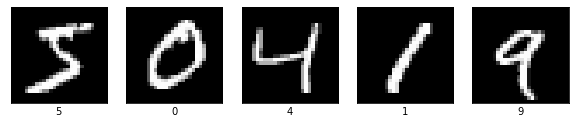

2020-11-01 07:48:51,420: INFO: finish 显示图片示例 [elapsed time: 0.81 seconds]


In [19]:
def tf_mnist_extract_data(dataset='mnist', classes=None):
    with TaskTime('获取数据', True):
        # 默认的保存路径是~/.keras/datasets/
        if dataset=='mnist':
            (train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
        else:
            (train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

        # Normalize pixel values to be between 0 and 1
        train_images, test_images = train_images / 255.0, test_images / 255.0     

        print(train_images.shape, train_labels.shape, train_images.shape, test_labels.shape)
        print(type(train_images), type(train_labels.shape))

    with TaskTime('显示图片示例', True):

        plt.figure(figsize=(10,2))
        for i in range(5):
            plt.subplot(1,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(train_images[i], cmap='gray', interpolation='none')
            # The CIFAR labels happen to be arrays, 
            # which is why you need the extra index
            plt.xlabel(train_labels[i] if classes is None else classes[train_labels[i]])
        plt.show()
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = tf_mnist_extract_data()

![image-20201026113532842](images/image-20201026113532842.png)

接下来是模型创建，模型训练，保存加载，以及模型评估的代码。

2020-11-01 07:50:41,924: INFO: start 创建模型
2020-11-01 07:50:42,488: INFO: finish 创建模型 [elapsed time: 0.56 seconds]
2020-11-01 07:50:42,491: INFO: start 显示参数


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


2020-11-01 07:50:42,994: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 07:50:42,995: INFO: start 模型训练


Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2980 - accuracy: 0.9142 - val_loss: 0.1449 - val_accuracy: 0.9558
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1474 - accuracy: 0.9552 - val_loss: 0.1028 - val_accuracy: 0.9684
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1076 - accuracy: 0.9674 - val_loss: 0.0877 - val_accuracy: 0.9722
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0887 - accuracy: 0.9729 - val_loss: 0.0810 - val_accuracy: 0.9740
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0763 - accuracy: 0.9763 - val_loss: 0.0794 - val_accuracy: 0.9763


2020-11-01 07:51:03,512: INFO: finish 模型训练 [elapsed time: 20.52 seconds]
2020-11-01 07:51:03,513: INFO: start 保存，加载模型
2020-11-01 07:51:04,107: INFO: finish 保存，加载模型 [elapsed time: 0.59 seconds]
2020-11-01 07:51:04,108: INFO: start 评估模型


1875/1875 - 3s - loss: 0.0429 - accuracy: 0.9872
313/313 - 1s - loss: 0.0794 - accuracy: 0.9763
Train Accuracy: 98.7%, Test Accuracy: 97.6%


2020-11-01 07:51:08,568: INFO: finish 评估模型 [elapsed time: 4.46 seconds]


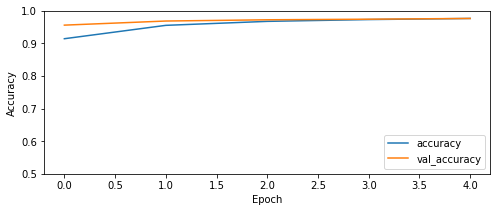

In [21]:
def tf_train_evaluate(model, epochs=2, save_model=False, model_file_name='tf_nn.h5'):   
    with TaskTime('显示参数', True):
        model.summary()

    with TaskTime('模型训练', True):    
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        history = model.fit(train_images, train_labels, epochs=epochs, batch_size=32,
                            validation_data=(test_images, test_labels))

    if save_model:
        with TaskTime('保存，加载模型', True): 
            model_root_path = os.path.join(os.path.expanduser('~'), '.keras/model') 
            if not os.path.exists(model_root_path): os.makedirs(model_root_path)
            model_path = os.path.join(model_root_path, model_file_name)
            model.save(model_path) 
            model = tf.keras.models.load_model(model_path)  

    with TaskTime('评估模型', True): 
        plt.figure(figsize=(8, 3))
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0.5, 1])
        plt.legend(loc='lower right')

        train_loss, train_acc = model.evaluate(train_images,  train_labels, verbose=2)
        test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
        print('Train Accuracy: {:0.1f}%, Test Accuracy: {:0.1f}%'.format(100 * train_acc, 100*test_acc)) 

with TaskTime('创建模型', True): 
    model = neural_network( )

tf_train_evaluate(model, epochs=5, save_model=True, model_file_name='tf_nn.h5')

![image-20201026114421894](images/image-20201026114421894.png)

Accuracy比pytorch明显更加一点，超过97%，效果非常不错。

## LeNet模型

下面尝试用[LeNet5](https://eipi10.cn/deep-learning/2020/10/23/lenet/)来实现，看看是不是还能有提高。下面是LeNet5的结构图。

![image-20201019113632136](images/image-20201019113632136.png)

### pytorch

在LeNet5中，输入层是$32\times32$的图片，而MNIST是$28\times28$的图片，为了保持模型的结构不变，在第一个卷积积增加一个参数padding=2。

In [22]:
class LeNet(nn.Module):
    def __init__(self, in_dim=1, n_class=10):
        super(LeNet, self).__init__()    

        self.conv1 = nn.Conv2d(in_dim, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_class)        
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

下面来训练LeNet。

2020-11-01 07:52:35,793: INFO: start 创建模型


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


2020-11-01 07:52:36,298: INFO: finish 创建模型 [elapsed time: 0.50 seconds]
2020-11-01 07:52:36,299: INFO: start 显示参数


10
torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


2020-11-01 07:52:36,802: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 07:52:36,803: INFO: start 模型训练


[epoch  1/5] loss: 0.046, accuracy: 0.984, val_loss: 0.078, val_accuracy: 0.968 
[epoch  2/5] loss: 0.025, accuracy: 0.992, val_loss: 0.057, val_accuracy: 0.980 
[epoch  3/5] loss: 0.047, accuracy: 0.984, val_loss: 0.061, val_accuracy: 0.982 
[epoch  4/5] loss: 0.018, accuracy: 0.993, val_loss: 0.054, val_accuracy: 0.981 
[epoch  5/5] loss: 0.009, accuracy: 0.998, val_loss: 0.049, val_accuracy: 0.984 


2020-11-01 07:53:55,353: INFO: finish 模型训练 [elapsed time: 78.55 seconds]
2020-11-01 07:53:55,354: INFO: start 评估模型


Train Accuracy: 0.995, Test Accuracy: 0.990


2020-11-01 07:54:07,397: INFO: finish 评估模型 [elapsed time: 12.04 seconds]


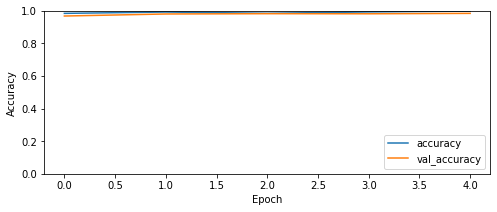

In [24]:
with TaskTime('创建模型', True):      
    net = LeNet(in_dim=1, n_class=10)
    print(net)

torch_train_evaluate(net, epochs=5)

![image-20201026120641942](images/image-20201026120641942.png)

经过5个epoch，accuracy有一些提高，能达到将近99%，非常理想。

### tensorflow

同样为了保持模型的结构不变，设置一个参数padding='same'，另外input_shape改成了(28, 28, in_dim)。

In [25]:
def lenet(in_dim=1, n_class=10):
    model = models.Sequential()
    model.add(layers.Conv2D(6, (5, 5), activation='relu', padding='same', input_shape=(28, 28, in_dim)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(n_class))    
    return model

由于采用卷积神经网络，需要有channel，所以对数据增加一个维度。

In [26]:
train_images = tf.expand_dims(train_images, axis=-1)
test_images = tf.expand_dims(test_images, axis=-1)

下面来训练lenet。

2020-11-01 07:54:55,262: INFO: start 创建模型
2020-11-01 07:54:55,851: INFO: finish 创建模型 [elapsed time: 0.59 seconds]
2020-11-01 07:54:55,853: INFO: start 显示参数


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_5 (Dense)              (None, 84)               

2020-11-01 07:54:56,357: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 07:54:56,358: INFO: start 模型训练


Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1808 - accuracy: 0.9438 - val_loss: 0.0828 - val_accuracy: 0.9743
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0571 - accuracy: 0.9819 - val_loss: 0.0553 - val_accuracy: 0.9837
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0422 - accuracy: 0.9863 - val_loss: 0.0339 - val_accuracy: 0.9887
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0326 - accuracy: 0.9895 - val_loss: 0.0406 - val_accuracy: 0.9874
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0278 - accuracy: 0.9909 - val_loss: 0.0344 - val_accuracy: 0.9890


2020-11-01 07:55:26,343: INFO: finish 模型训练 [elapsed time: 29.98 seconds]
2020-11-01 07:55:26,344: INFO: start 评估模型


1875/1875 - 4s - loss: 0.0190 - accuracy: 0.9940
313/313 - 1s - loss: 0.0344 - accuracy: 0.9890
Train Accuracy: 99.4%, Test Accuracy: 98.9%


2020-11-01 07:55:31,277: INFO: finish 评估模型 [elapsed time: 4.93 seconds]


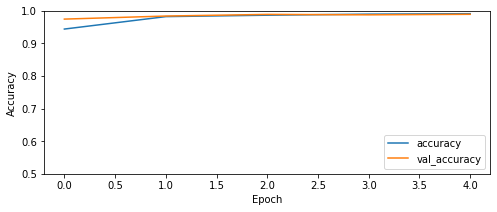

In [27]:
with TaskTime('创建模型', True): 
    model = lenet(in_dim=1, n_class=10)

tf_train_evaluate(model, epochs=5)

![image-20201026121110346](images/image-20201026121110346.png)

![image-20201026121127180](images/image-20201026121127180.png)

同样，比起经典神经网络，accuracy又提高了一点，接近99%，非常好。

## Fashion MNIST

对于MNIST数据集，无论采用经典神经网络还是LeNet都能取得不错的效果，LeNet收敛速度更快，Accuracy也高一点。下面来尝试一下[Fashion MNIST](https://eipi10.cn/others/2020/10/22/dataset/#fashion-mnist)数据集，这个数据集和MNIST的结构完全相同，代码可以几乎不用修改。

### pytorch

首先下载数据。

2020-11-01 08:00:56,478: INFO: start 获取数据
2020-11-01 08:00:57,008: INFO: finish 获取数据 [elapsed time: 0.53 seconds]
2020-11-01 08:00:57,009: INFO: start 显示图片示例


torch.Size([32, 1, 28, 28])
Shirt Coat Dress Bag Dress Pullover Bag Sandal


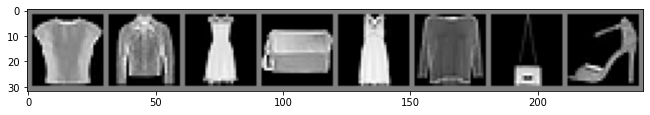

2020-11-01 08:00:57,836: INFO: finish 显示图片示例 [elapsed time: 0.83 seconds]


In [32]:
classes=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']
trainset, trainloader, testset, testloader = torch_mnist_extract_data(dataset='fashion-mnist', classes=classes) 

![image-20201028092402301](images/image-20201028092402301.png)

接下来开始训练模型，第一个看经典的神经网络。

2020-11-01 07:57:11,754: INFO: start 创建模型


NN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (drop_layer): Dropout(p=0.2, inplace=False)
)


2020-11-01 07:57:12,258: INFO: finish 创建模型 [elapsed time: 0.50 seconds]
2020-11-01 07:57:12,259: INFO: start 显示参数


4
torch.Size([128, 784])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


2020-11-01 07:57:12,762: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 07:57:12,763: INFO: start 模型训练


[epoch  1/5] loss: 0.403, accuracy: 0.854, val_loss: 0.438, val_accuracy: 0.845 
[epoch  2/5] loss: 0.397, accuracy: 0.844, val_loss: 0.396, val_accuracy: 0.856 
[epoch  3/5] loss: 0.380, accuracy: 0.855, val_loss: 0.394, val_accuracy: 0.862 
[epoch  4/5] loss: 0.374, accuracy: 0.858, val_loss: 0.395, val_accuracy: 0.848 
[epoch  5/5] loss: 0.318, accuracy: 0.884, val_loss: 0.376, val_accuracy: 0.868 


2020-11-01 07:58:07,468: INFO: finish 模型训练 [elapsed time: 54.71 seconds]
2020-11-01 07:58:07,470: INFO: start 评估模型


Train Accuracy: 0.879, Test Accuracy: 0.857


2020-11-01 07:58:19,563: INFO: finish 评估模型 [elapsed time: 12.09 seconds]


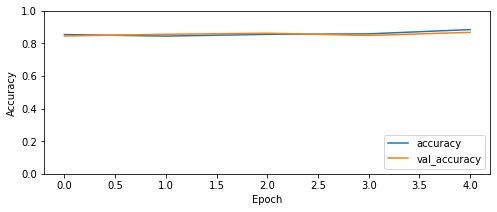

In [29]:
with TaskTime('创建模型', True):      
    net = NN(in_dim=1, n_class=10)
    print(net)

torch_train_evaluate(net, epochs=5)

![image-20201028092721943](images/image-20201028092721943.png)

Accuracy只有85%，下面再来看LeNet。

2020-11-01 08:06:03,788: INFO: start 创建模型


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


2020-11-01 08:06:04,293: INFO: finish 创建模型 [elapsed time: 0.51 seconds]
2020-11-01 08:06:04,294: INFO: start 显示参数


10
torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


2020-11-01 08:06:04,797: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 08:06:04,798: INFO: start 模型训练


[epoch  1/5] loss: 0.363, accuracy: 0.871, val_loss: 0.396, val_accuracy: 0.866 
[epoch  2/5] loss: 0.300, accuracy: 0.882, val_loss: 0.330, val_accuracy: 0.879 
[epoch  3/5] loss: 0.260, accuracy: 0.904, val_loss: 0.302, val_accuracy: 0.896 
[epoch  4/5] loss: 0.227, accuracy: 0.916, val_loss: 0.276, val_accuracy: 0.901 
[epoch  5/5] loss: 0.232, accuracy: 0.909, val_loss: 0.299, val_accuracy: 0.903 


2020-11-01 08:07:23,569: INFO: finish 模型训练 [elapsed time: 78.77 seconds]
2020-11-01 08:07:23,570: INFO: start 评估模型


Train Accuracy: 0.910, Test Accuracy: 0.887


2020-11-01 08:07:35,773: INFO: finish 评估模型 [elapsed time: 12.20 seconds]


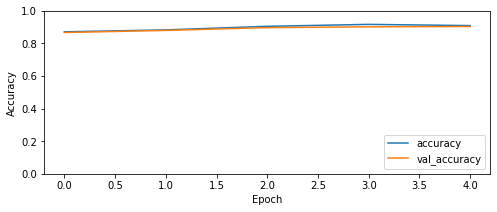

In [35]:
with TaskTime('创建模型', True):      
    net = LeNet(in_dim=1, n_class=10)
    print(net)

torch_train_evaluate(net, epochs=5)

![image-20201028092924485](images/image-20201028092924485.png)

Accuracy提高到了89%，不错。下面来看一种改进的LeNet。它增加了一层卷积，并大大增加了卷积的深度，同时减少了一层全连接层（或许可以减少一些过拟合）。

2020-11-01 08:08:21,195: INFO: start 创建模型


LeNet1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


2020-11-01 08:08:21,701: INFO: finish 创建模型 [elapsed time: 0.51 seconds]
2020-11-01 08:08:21,702: INFO: start 显示参数


10
torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64, 1024])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


2020-11-01 08:08:22,204: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 08:08:22,206: INFO: start 模型训练


[epoch  1/5] loss: 0.285, accuracy: 0.888, val_loss: 0.343, val_accuracy: 0.873 
[epoch  2/5] loss: 0.288, accuracy: 0.896, val_loss: 0.298, val_accuracy: 0.899 
[epoch  3/5] loss: 0.235, accuracy: 0.912, val_loss: 0.263, val_accuracy: 0.909 
[epoch  4/5] loss: 0.191, accuracy: 0.928, val_loss: 0.240, val_accuracy: 0.903 
[epoch  5/5] loss: 0.174, accuracy: 0.939, val_loss: 0.253, val_accuracy: 0.916 


2020-11-01 08:09:42,931: INFO: finish 模型训练 [elapsed time: 80.73 seconds]
2020-11-01 08:09:42,933: INFO: start 评估模型


Train Accuracy: 0.939, Test Accuracy: 0.911


2020-11-01 08:09:55,117: INFO: finish 评估模型 [elapsed time: 12.18 seconds]


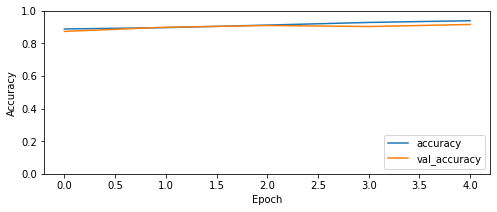

In [36]:
class LeNet1(nn.Module):
    def __init__(self, in_dim=1, n_class=10):
        super(LeNet1, self).__init__()    

        self.conv1 = nn.Conv2d(in_dim, 32, 3, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)  
        self.fc2 = nn.Linear(64, n_class)        
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
with TaskTime('创建模型', True):      
    net = LeNet1(in_dim=1, n_class=10)
    print(net)

torch_train_evaluate(net, epochs=5)

![image-20201028093718791](images/image-20201028093718791.png)

Accuracy继续提高到了91%。增加卷积的深度，看来还是有用的。

### tensorflow

首先也是下载数据。

2020-11-01 08:10:39,314: INFO: start 获取数据


(60000, 28, 28) (60000,) (60000, 28, 28) (10000,)
<class 'numpy.ndarray'> <class 'tuple'>


2020-11-01 08:10:40,635: INFO: finish 获取数据 [elapsed time: 1.32 seconds]
2020-11-01 08:10:40,637: INFO: start 显示图片示例


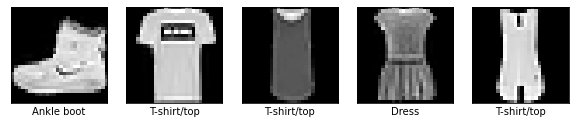

2020-11-01 08:10:41,446: INFO: finish 显示图片示例 [elapsed time: 0.81 seconds]


In [38]:
classes=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images, train_labels, test_images, test_labels = tf_mnist_extract_data(dataset='fashion-mnist', classes=classes)

![image-20201028094735210](images/image-20201028094735210.png)

接下来开始训练模型，第一个看经典的神经网络。

2020-11-01 08:11:04,404: INFO: start 创建模型
2020-11-01 08:11:04,974: INFO: finish 创建模型 [elapsed time: 0.57 seconds]
2020-11-01 08:11:04,976: INFO: start 显示参数


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


2020-11-01 08:11:05,480: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 08:11:05,481: INFO: start 模型训练


Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5352 - accuracy: 0.8111 - val_loss: 0.4210 - val_accuracy: 0.8497
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4004 - accuracy: 0.8546 - val_loss: 0.3782 - val_accuracy: 0.8633
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3660 - accuracy: 0.8662 - val_loss: 0.3646 - val_accuracy: 0.8699
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3434 - accuracy: 0.8747 - val_loss: 0.3910 - val_accuracy: 0.8549
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3289 - accuracy: 0.8799 - val_loss: 0.3543 - val_accuracy: 0.8736


2020-11-01 08:11:26,069: INFO: finish 模型训练 [elapsed time: 20.59 seconds]
2020-11-01 08:11:26,071: INFO: start 评估模型


1875/1875 - 3s - loss: 0.2823 - accuracy: 0.8934
313/313 - 0s - loss: 0.3543 - accuracy: 0.8736
Train Accuracy: 89.3%, Test Accuracy: 87.4%


2020-11-01 08:11:30,578: INFO: finish 评估模型 [elapsed time: 4.51 seconds]


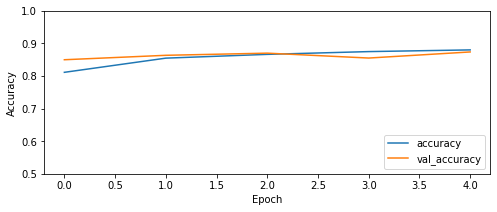

In [39]:
with TaskTime('创建模型', True): 
    model = neural_network( )

tf_train_evaluate(model, epochs=5)

![image-20201028095215543](images/image-20201028095215543.png)

Accuracy只有87%左右，下面再来看LeNet。别忘了由于采用卷积神经网络，需要有channel，所以对数据增加一个维度。

In [41]:
train_images = tf.expand_dims(train_images, axis=-1)
test_images = tf.expand_dims(test_images, axis=-1)

# 下面两行代码可以实现上面相同的逻辑
# train_images = train_images[..., np.newaxis]
# test_images = test_images[..., np.newaxis]

训练代码如下：

2020-11-01 08:12:55,633: INFO: start 创建模型
2020-11-01 08:12:56,213: INFO: finish 创建模型 [elapsed time: 0.58 seconds]
2020-11-01 08:12:56,215: INFO: start 显示参数


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_13 (Dense)             (None, 84)               

2020-11-01 08:12:56,719: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 08:12:56,720: INFO: start 模型训练


Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5107 - accuracy: 0.8131 - val_loss: 0.3941 - val_accuracy: 0.8614
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3469 - accuracy: 0.8718 - val_loss: 0.3345 - val_accuracy: 0.8787
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3022 - accuracy: 0.8894 - val_loss: 0.3316 - val_accuracy: 0.8790
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2770 - accuracy: 0.8969 - val_loss: 0.3187 - val_accuracy: 0.8818
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2530 - accuracy: 0.9056 - val_loss: 0.2956 - val_accuracy: 0.8929


2020-11-01 08:13:25,609: INFO: finish 模型训练 [elapsed time: 28.89 seconds]
2020-11-01 08:13:25,610: INFO: start 评估模型


1875/1875 - 4s - loss: 0.2276 - accuracy: 0.9136
313/313 - 1s - loss: 0.2956 - accuracy: 0.8929
Train Accuracy: 91.4%, Test Accuracy: 89.3%


2020-11-01 08:13:30,530: INFO: finish 评估模型 [elapsed time: 4.92 seconds]


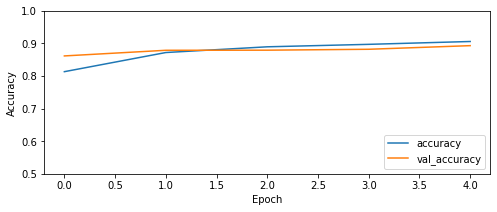

In [42]:
with TaskTime('创建模型', True): 
    model = lenet(in_dim=1, n_class=10)

tf_train_evaluate(model, epochs=5)

![image-20201028100025596](images/image-20201028100025596.png)

和pytorch一样，Accuracy同样提高到了89%。然后看改进的LeNet。它增加了一层卷积，并大大增加了卷积的深度，同时减少了一层全连接层（或许可以减少一些过拟合）。

2020-11-01 08:14:45,334: INFO: start 创建模型
2020-11-01 08:14:45,932: INFO: finish 创建模型 [elapsed time: 0.60 seconds]
2020-11-01 08:14:45,934: INFO: start 显示参数


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

2020-11-01 08:14:46,437: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 08:14:46,438: INFO: start 模型训练


Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4437 - accuracy: 0.8369 - val_loss: 0.3450 - val_accuracy: 0.8738
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2890 - accuracy: 0.8938 - val_loss: 0.2785 - val_accuracy: 0.8950
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2436 - accuracy: 0.9092 - val_loss: 0.2622 - val_accuracy: 0.9042
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2135 - accuracy: 0.9206 - val_loss: 0.2663 - val_accuracy: 0.9073
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1914 - accuracy: 0.9290 - val_loss: 0.2431 - val_accuracy: 0.9126


2020-11-01 08:15:16,797: INFO: finish 模型训练 [elapsed time: 30.36 seconds]
2020-11-01 08:15:16,799: INFO: start 评估模型


1875/1875 - 4s - loss: 0.1660 - accuracy: 0.9394
313/313 - 1s - loss: 0.2431 - accuracy: 0.9126
Train Accuracy: 93.9%, Test Accuracy: 91.3%


2020-11-01 08:15:27,202: INFO: finish 评估模型 [elapsed time: 10.40 seconds]


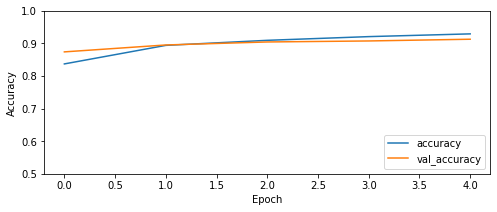

In [43]:
def lenet1(in_dim=1, n_class=10):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, in_dim)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(n_class))    
    return model

with TaskTime('创建模型', True): 
    model = lenet1(in_dim=1, n_class=10)

tf_train_evaluate(model, epochs=5)

2020-11-01 08:16:56,113: INFO: start 显示参数


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

2020-11-01 08:16:56,617: INFO: finish 显示参数 [elapsed time: 0.50 seconds]
2020-11-01 08:16:56,619: INFO: start 模型训练


Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1738 - accuracy: 0.9350 - val_loss: 0.2308 - val_accuracy: 0.9166
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1550 - accuracy: 0.9416 - val_loss: 0.2453 - val_accuracy: 0.9156
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1380 - accuracy: 0.9478 - val_loss: 0.2487 - val_accuracy: 0.9160
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1230 - accuracy: 0.9539 - val_loss: 0.2530 - val_accuracy: 0.9197
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1139 - accuracy: 0.9570 - val_loss: 0.2542 - val_accuracy: 0.9173


2020-11-01 08:17:26,968: INFO: finish 模型训练 [elapsed time: 30.35 seconds]
2020-11-01 08:17:26,969: INFO: start 评估模型


1875/1875 - 4s - loss: 0.0976 - accuracy: 0.9642
313/313 - 1s - loss: 0.2542 - accuracy: 0.9173
Train Accuracy: 96.4%, Test Accuracy: 91.7%


2020-11-01 08:17:32,080: INFO: finish 评估模型 [elapsed time: 5.11 seconds]


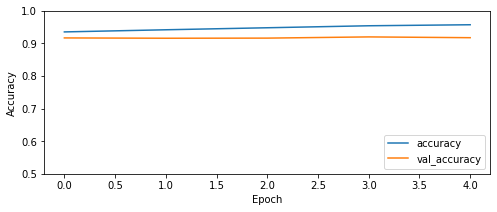

In [44]:
tf_train_evaluate(model, epochs=5)

![image-20201028100413237](images/image-20201028100413237.png)

同样，Accuracy也提高到了91%。如果再训练5个epoch，得到结果如下。

![image-20201028100558373](images/image-20201028100558373.png)

准确率还是91%多，但过拟合明显严重多了，看来要继续改进模型结构才可以啊。

## 总结

归纳上面的模型训练结果，可以得出以下几个结论。

- LeNet比经典的神经网络参数要少，模型收敛更快，准确率明显提升。
- MNIST数据集过于简单了，很简单的算法也能轻易取得99%的准确率。建议采用Fashion MNIST作为替代。
- 增加卷积的深度，对于准确率的提升是有明显作用的。
- 本文中，对于Fashion MNIST最好只能取得91%的准确率，还需要采用新的模型结构才能继续提升。

## 参考

- [TensorFlow 2 quickstart for beginners](https://www.tensorflow.org/tutorials/quickstart/beginner)

## 历史

- 2020-10-26：初始版本
- 2020-10-28：采用相同算法，对Fashion Mnist数据集进行分类